#PENGURANGAN NOISE PADA SINYAL AUDIO DENGAN KOMBINASI AUTOENCODER DAN WAVELET TRANSFORM #

#SOFYAN_22.11.5099#

In [1]:
!pip install pywavelets tensorflow librosa matplotlib soundfile


In [3]:
# Import libraries
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models
import soundfile as sf
from IPython.display import Audio, display
import scipy.signal

In [4]:
# ===== Wavelet + Autoencoder functions =====

def wavelet_decompose(signal, wavelet='db8', level=4):
    return pywt.wavedec(signal, wavelet=wavelet, level=level)

def coeffs_to_vector(coeffs):
    return np.concatenate(coeffs)

def vector_to_coeffs(vector, coeffs_template):
    sizes = [len(c) for c in coeffs_template]
    split_coeffs = []
    idx = 0
    for size in sizes:
        split_coeffs.append(vector[idx:idx+size])
        idx += size
    return split_coeffs

def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(encoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    model = models.Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

def denoise_with_wavelet_autoencoder(signal):
    coeffs = wavelet_decompose(signal)
    coeff_vector = coeffs_to_vector(coeffs)
    model = build_autoencoder(len(coeff_vector))
    X_train = np.tile(coeff_vector, (10, 1))  # dummy training
    model.fit(X_train, X_train, epochs=10, verbose=0)
    denoised_vector = model.predict(np.expand_dims(coeff_vector, axis=0))[0]
    reconstructed_coeffs = vector_to_coeffs(denoised_vector, coeffs)
    return pywt.waverec(reconstructed_coeffs, wavelet='db8')


In [5]:
# Fungsi wavelet denoising
def wavelet_denoise(data, wavelet='db8', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745 * np.sqrt(2 * np.log(len(data)))
    coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs_thresh, wavelet)

In [6]:
# Fungsi autoencoder
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(encoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    model = models.Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model


In [7]:
# Fungsi untuk playback audio interaktif
def play_audio(audio, sr):
    display(Audio(audio, rate=sr))

In [8]:
# Fungsi visualisasi waveform
def plot_waveform(audio, sr, title='Waveform'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [9]:
# Fungsi visualisasi spektrogram
def plot_spectrogram(audio, sr, title='Spectrogram'):
    D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [10]:
# Fungsi noise reduction menggunakan STFT masking
def removeNoise(audio, sr, visual=False):
    # Noise reduction with STFT masking
    D = librosa.stft(audio)
    D_mag, D_phase = librosa.magphase(D)
    mean_mag = np.mean(D_mag, axis=1, keepdims=True)
    std_mag = np.std(D_mag, axis=1, keepdims=True)

    # Masking
    noise_mask = D_mag > (mean_mag + 2 * std_mag)
    D_clean = D * noise_mask

    # Reconstruct the audio signal from clean STFT
    cleaned_audio = librosa.istft(D_clean)

    if visual:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(D_mag, ref=np.max), x_axis='time', y_axis='log', sr=sr)
        plt.title('Spectrogram (Noise)')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

        # Masking Visualization
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(D_clean, ref=np.max), x_axis='time', y_axis='log', sr=sr)
        plt.title('Spectrogram (After Masking)')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    return cleaned_audio

In [11]:
# Fungsi untuk PCEN (Perceptual Cepstral Normalization)
def pcen(audio):
    # Placeholder PCEN function (use an actual implementation in practice)
    return librosa.effects.preemphasis(audio)

In [13]:
# Load file audio
file_path_1 = 'birdsong1.wav'  # Ganti dengan path file wav pertama kamu
file_path_2 = 'birdsong2.wav'  # Ganti dengan path file wav kedua kamu
y1, sr1 = librosa.load(file_path_1, sr=16000)
y2, sr2 = librosa.load(file_path_2, sr=16000)

In [14]:
# High-pass filter (contoh filter sederhana)
def high_pass_filter(audio, cutoff_freq=300):
    b, a = scipy.signal.butter(4, cutoff_freq / (0.5 * 16000), btype='high')
    return scipy.signal.filtfilt(b, a, audio)

In [15]:
# Proses audio 1
yf1 = high_pass_filter(y1)
yp1 = pcen(yf1)
yg1 = removeNoise(yp1, sr1, visual=False)
y1_clean = denoise_with_wavelet_autoencoder(y1)


# Proses audio 2
yf2 = high_pass_filter(y2)
yp2 = pcen(yf2)
yg2 = removeNoise(yp2, sr2, visual=False)
y2_clean = denoise_with_wavelet_autoencoder(y2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


1. Playing Audio 1 - Original


2. Playing Audio 2 - After Reduction


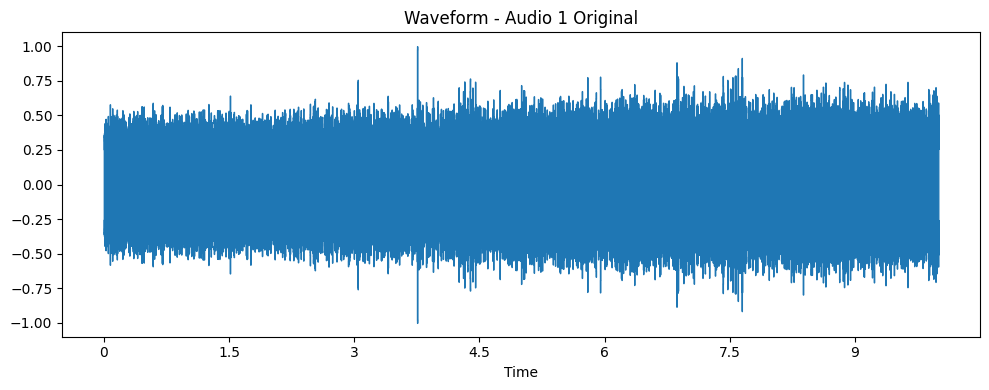

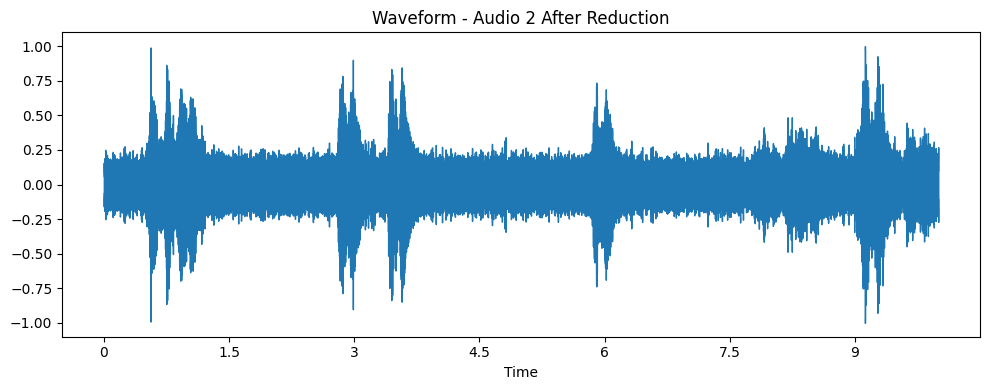

/tmp/ipython-input-1696379074.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


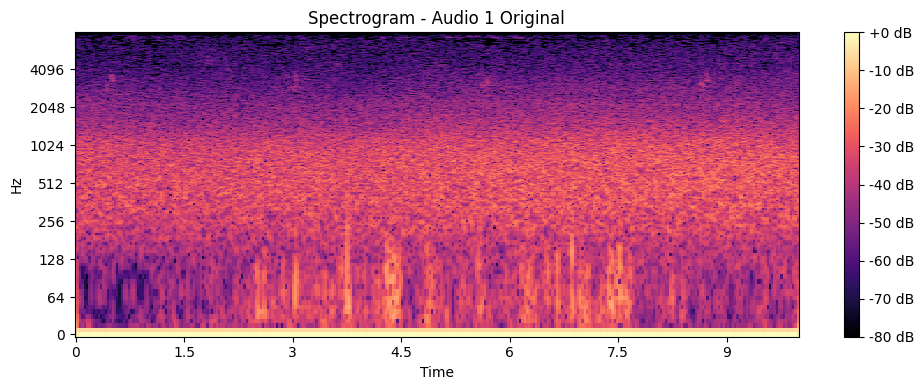

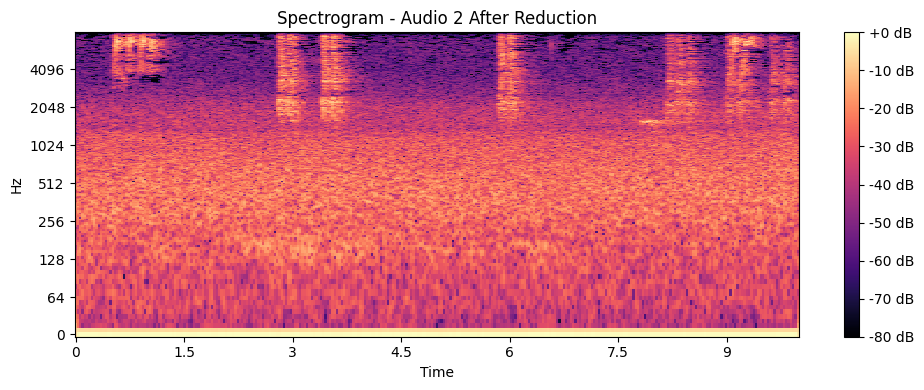

In [16]:
# 1. Playing Audio 1 - Original
print("1. Playing Audio 1 - Original")
display(Audio(y1, rate=sr1))

# 2. Playing Audio 2 - Original
print("2. Playing Audio 2 - After Reduction")
display(Audio(y2, rate=sr2))

# Visualisasi Gelombang
plot_waveform(y1, sr1, title="Waveform - Audio 1 Original")
plot_waveform(y2, sr2, title="Waveform - Audio 2 After Reduction")

# Visualisasi Spektrogram
plot_spectrogram(y1, sr1, title="Spectrogram - Audio 1 Original")
plot_spectrogram(y2, sr2, title="Spectrogram - Audio 2 After Reduction")


1. Playing Audio 1 - After High-pass Filter


2. Playing Audio 2 - After High-pass Filter_After Reduction


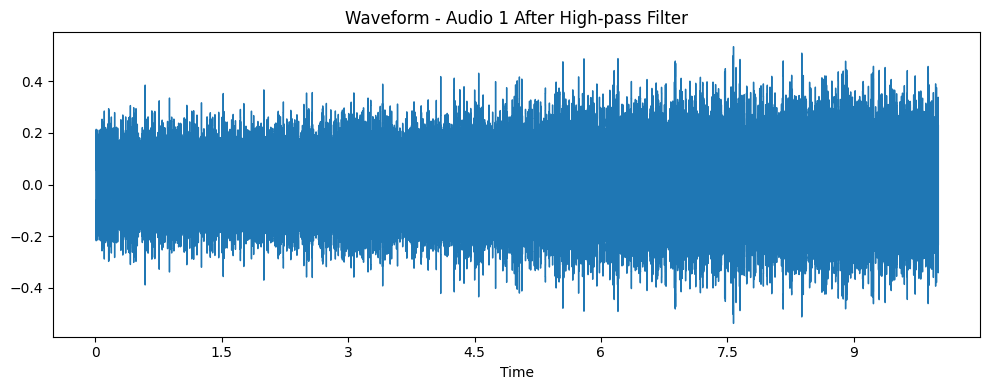

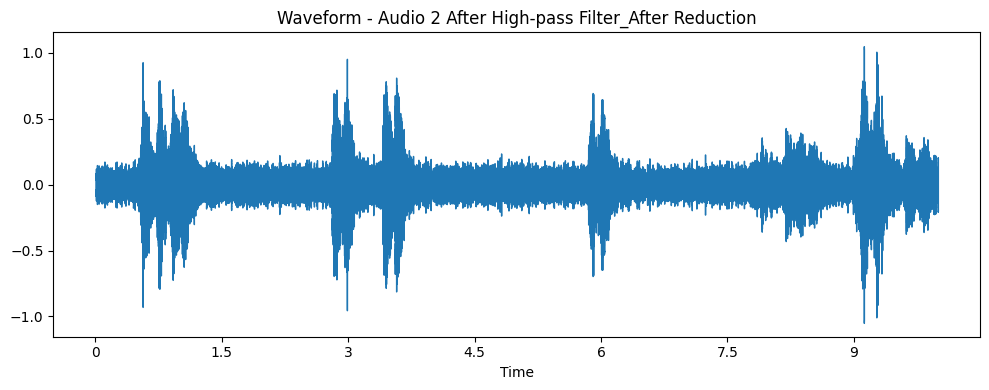

/tmp/ipython-input-1696379074.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


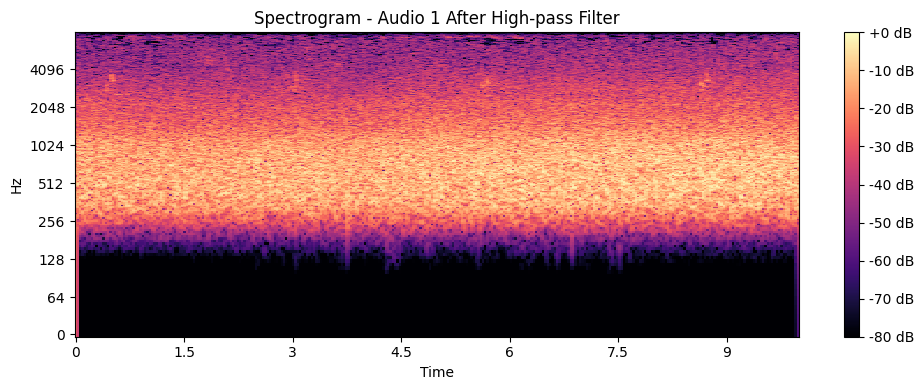

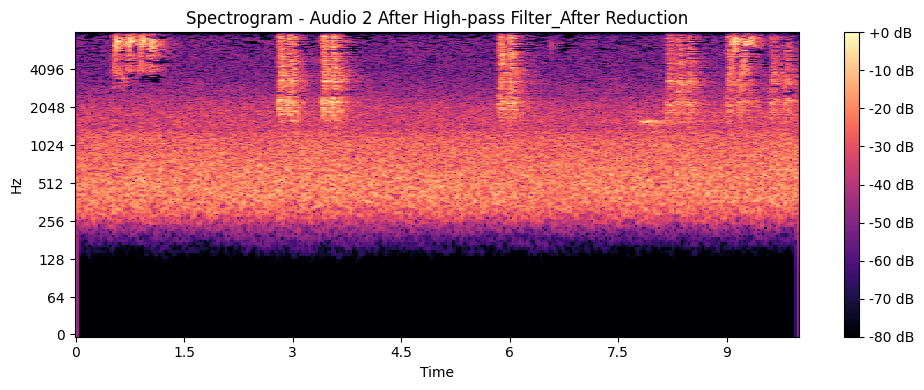

In [17]:
# 1. Playing Audio 1 - After High-pass Filter
print("1. Playing Audio 1 - After High-pass Filter")
display(Audio(yf1, rate=sr1))

# 2. Playing Audio 2 - After High-pass Filter
print("2. Playing Audio 2 - After High-pass Filter_After Reduction")
display(Audio(yf2, rate=sr2))

# Visualisasi Gelombang
plot_waveform(yf1, sr1, title="Waveform - Audio 1 After High-pass Filter")
plot_waveform(yf2, sr2, title="Waveform - Audio 2 After High-pass Filter_After Reduction")

# Visualisasi Spektrogram
plot_spectrogram(yf1, sr1, title="Spectrogram - Audio 1 After High-pass Filter")
plot_spectrogram(yf2, sr2, title="Spectrogram - Audio 2 After High-pass Filter_After Reduction")


1. Playing Audio 1 - After PCEN


2. Playing Audio 2 - After PCEN_After Reduction


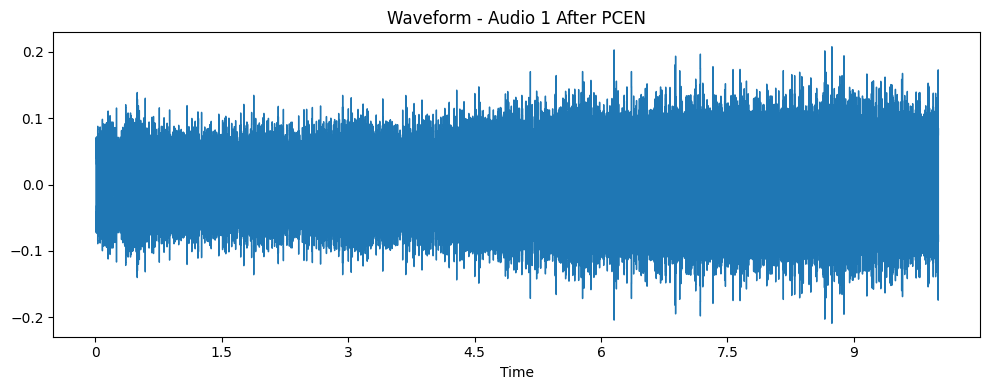

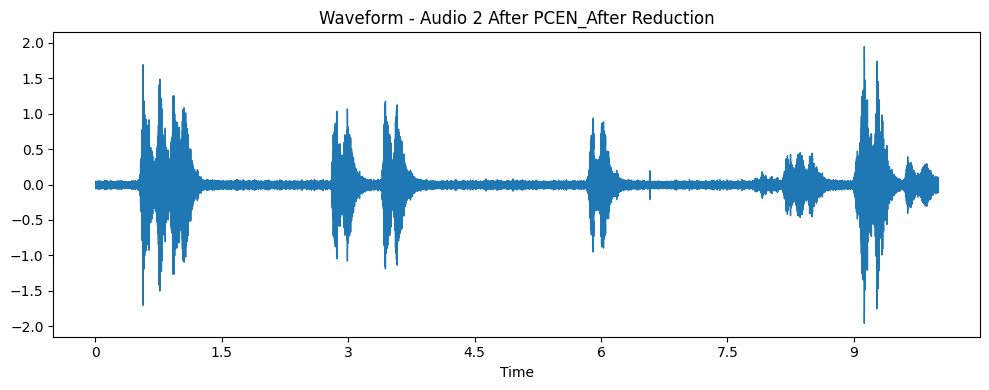

/tmp/ipython-input-1696379074.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


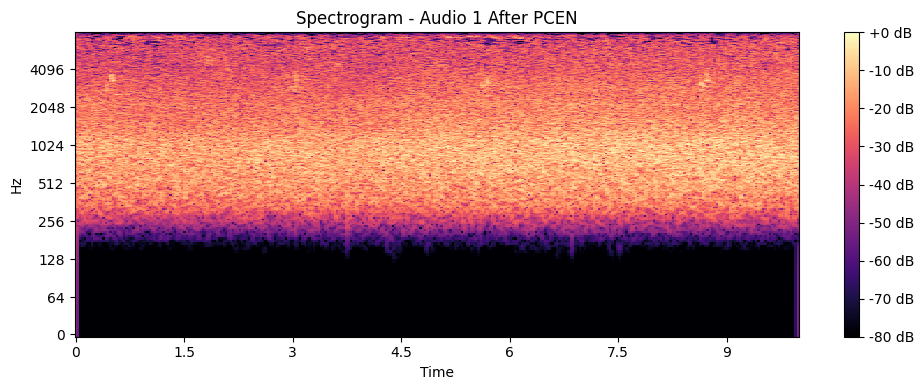

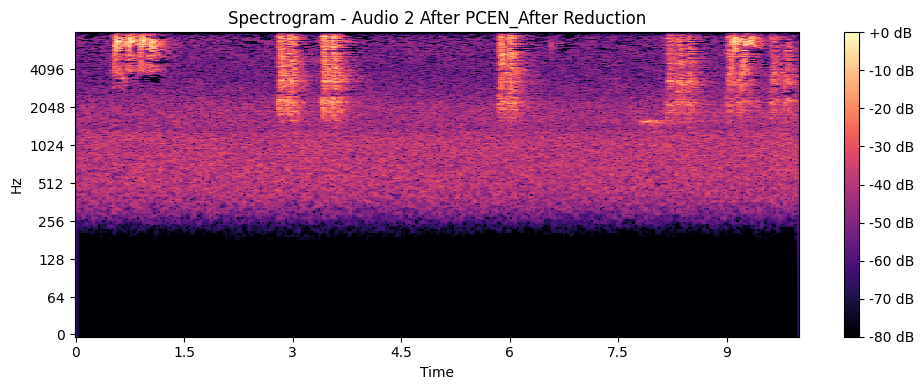

In [18]:
# 1. Playing Audio 1 - After PCEN
print("1. Playing Audio 1 - After PCEN")
display(Audio(yp1, rate=sr1))

# 2. Playing Audio 2 - After PCEN
print("2. Playing Audio 2 - After PCEN_After Reduction")
display(Audio(yp2, rate=sr2))

# Visualisasi Gelombang
plot_waveform(yp1, sr1, title="Waveform - Audio 1 After PCEN")
plot_waveform(yp2, sr2, title="Waveform - Audio 2 After PCEN_After Reduction")

# Visualisasi Spektrogram
plot_spectrogram(yp1, sr1, title="Spectrogram - Audio 1 After PCEN")
plot_spectrogram(yp2, sr2, title="Spectrogram - Audio 2 After PCEN_After Reduction")


1. Playing Audio 1


2. Playing Audio 2 - After Noise Reduction


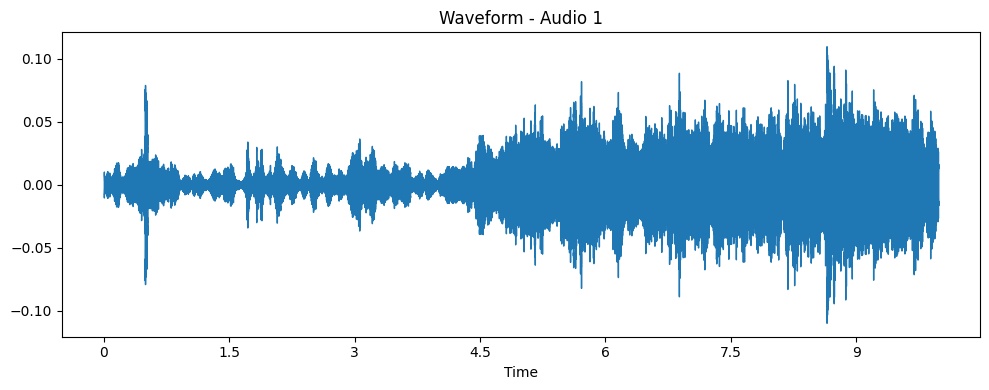

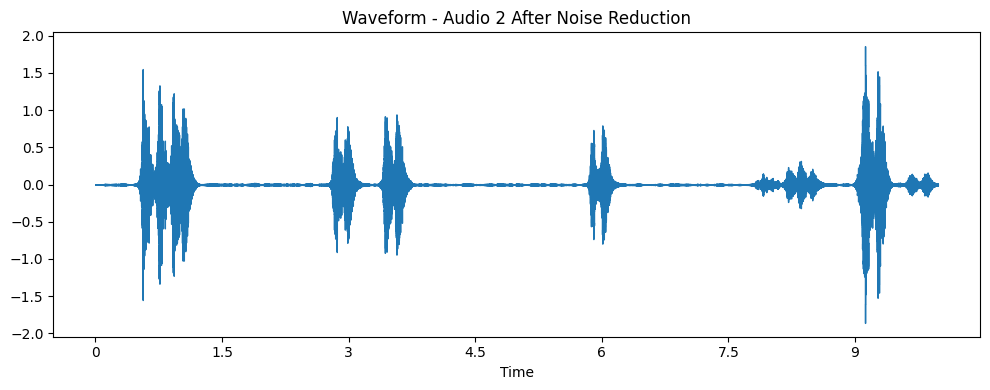

/tmp/ipython-input-1696379074.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


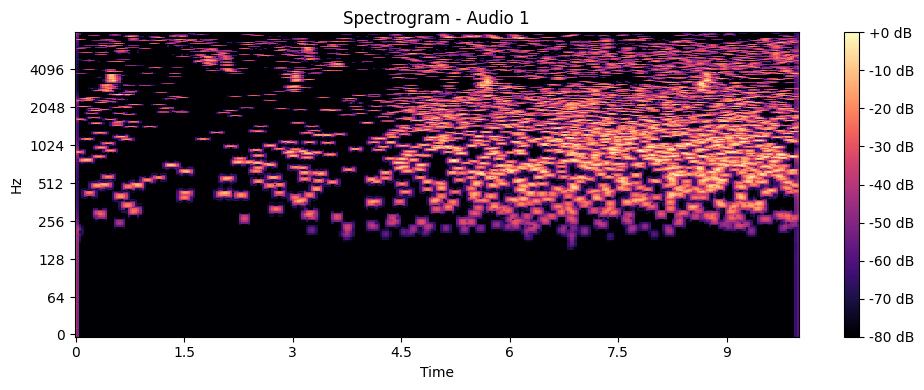

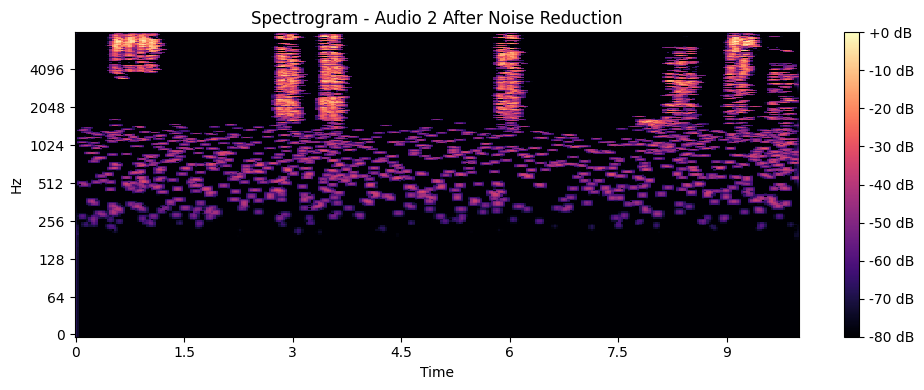

In [19]:
# 1. Playing Audio 1 - After Noise Reduction
print("1. Playing Audio 1")
display(Audio(yg1, rate=sr1))

# 2. Playing Audio 2 - After Noise Reduction
print("2. Playing Audio 2 - After Noise Reduction")
display(Audio(yg2, rate=sr2))

# Visualisasi Gelombang
plot_waveform(yg1, sr1, title="Waveform - Audio 1")
plot_waveform(yg2, sr2, title="Waveform - Audio 2 After Noise Reduction")

# Visualisasi Spektrogram
plot_spectrogram(yg1, sr1, title="Spectrogram - Audio 1")
plot_spectrogram(yg2, sr2, title="Spectrogram - Audio 2 After Noise Reduction")


In [25]:
# Latih model secara eksplisit (di luar fungsi)

# Step 1: Buat data input dari sinyal yang telah kamu load (y1)
coeffs = wavelet_decompose(y1)
coeff_vector = coeffs_to_vector(coeffs)
X_train = np.tile(coeff_vector, (10, 1))  # Dummy training

# Step 2: Bangun model
input_dim = len(coeff_vector)
model = build_autoencoder(input_dim)

# Step 3: Latih model
model.fit(X_train, X_train, epochs=10)

# Step 4: Simpan model
model.save("autoencoder_model.h5")


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0805
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0804
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0744
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0526
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0235
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0258
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0137
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0061
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0080
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0117


In [26]:
from google.colab import files
files.download("autoencoder_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>